In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler 
from statistics import mean
from scipy.stats.stats import pearsonr
from math import sqrt


In [20]:
###TRAIN DATA
trainData=pd.read_csv('..\\Data\\train_data.csv')
testData=pd.read_csv('..\\Data\\test_data.csv')

In [21]:
####SUMMARY
def summarize(df):
    head_df=df.head()
    df_col=df.columns
    shape=df.shape
    dtypes=df.dtypes
    summ=df.describe(include='all')
    return (head_df,df_col,shape,dtypes,summ)

In [22]:
# pd.options.display.float_format = '{:20,.2f}'.format
(head_df,df_col,shape,dtypes,summ)=summarize(trainData)
print('First few rows:\n',head_df)
print('Columns:\n',df_col)
print('Df shape:\n',shape)
print('Datatypes:\n',dtypes)
print('Summary:\n',summ)

First few rows:
        ID Tag  Reputation  Answers  Username  Views  Upvotes
0   52664   a        3942        2    155623   7855       42
1  327662   a       26046       12     21781  55801     1175
2  468453   c        1358        4     56177   8067       60
3   96996   a         264        3    168793  27064        9
4  131465   c        4271        4    112223  13986       83
Columns:
 Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')
Df shape:
 (330045, 7)
Datatypes:
 ID             int64
Tag           object
Reputation     int64
Answers        int64
Username       int64
Views          int64
Upvotes        int64
dtype: object
Summary:
                    ID     Tag    Reputation        Answers       Username  \
count   330045.000000  330045  3.300450e+05  330045.000000  330045.000000   
unique            NaN      10           NaN            NaN            NaN   
top               NaN       c           NaN            NaN            NaN   

In [23]:
trainData['Tag']=trainData['Tag'].astype('category')

In [24]:
####oUTLIER
def detect_outlier(col):
    out=[]
    threshold=3
    mean_1 = np.mean(col)
    std_1 =np.std(col)
    for y in col:
        z_score= (y - mean_1)/std_1
        if np.abs(z_score) > threshold:
            out.append(y)
#     print('Outliers:',out)
    if out is not None:
        return out
    else:
        return 0

In [25]:
#### PREPROCESS ( NULL + OUTLIER)
def preprocess_nullout(df):
    #null values\n",
    null=dict.fromkeys(df.columns)
    print(null.keys())
    for col in df.columns:
        null[col]=df[col].isna().sum()
        if(null[col]!=0):
             print('Column:',col,'Null records:',df.loc[df[col].isna()])
    print(null)
    #outliers\n",
    outliers=dict.fromkeys(df.columns)
    print(outliers.keys())
    for col in df.columns:
        if((df[col].dtypes=='int64')|(df[col].dtypes=='float64')):
            print(col)
            out=detect_outlier(df[col])
            if out:
                print('Outliers detected:',out)
                print('Records containing outliers:\n',df.loc[df[col]==out[0]])
            else:
                print("Outliers not detecred")

In [26]:
preprocess_nullout(trainData)

dict_keys(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'])
{'ID': 0, 'Tag': 0, 'Reputation': 0, 'Answers': 0, 'Username': 0, 'Views': 0, 'Upvotes': 0}
dict_keys(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'])
ID
Outliers not detecred
Reputation
Outliers detected: [94541, 93269, 125111, 164870, 249097, 139905, 126101, 170791, 241819, 229039, 189302, 174849, 248060, 89791, 198064, 99319, 126091, 113925, 89433, 737382, 150945, 233750, 120377, 150390, 120377, 293485, 212644, 191425, 117917, 114888, 100228, 502055, 128520, 161310, 335456, 121544, 119350, 119350, 96291, 103429, 247342, 109696, 91376, 123471, 149420, 157402, 126101, 103429, 203848, 101795, 157402, 94855, 177160, 121544, 357190, 103721, 102036, 100171, 156838, 105240, 89791, 161310, 271634, 212654, 120367, 189302, 177160, 231336, 123471, 107857, 272742, 128538, 242422, 114888, 158107, 252236, 215454, 179084, 108363, 301057, 198863, 327041, 750042, 93337, 92471, 335456, 154304, 119

                  ID  Reputation   Answers  Username     Views   Upvotes
ID          1.000000    0.008546  0.017448  0.000628  0.017400  0.006328
Reputation  0.008546    1.000000  0.066504 -0.041019  0.036455  0.266710
Answers     0.017448    0.066504  1.000000 -0.012197  0.498642  0.202033
Username    0.000628   -0.041019 -0.012197  1.000000  0.002306 -0.011970
Views       0.017400    0.036455  0.498642  0.002306  1.000000  0.437336
Upvotes     0.006328    0.266710  0.202033 -0.011970  0.437336  1.000000


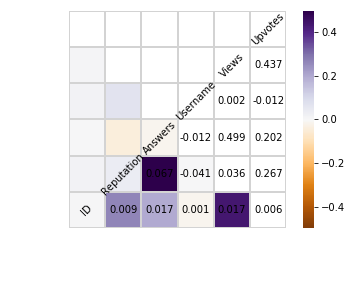

In [27]:
## correlation
# Compute the correlation matrix
corr = trainData.corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots()

# Draw the heatmap with the mask and correct aspect ratio
vmax = np.abs(corr.values[~mask]).max()
sns.heatmap(corr, mask=mask, cmap=plt.cm.PuOr, vmin=-vmax, vmax=vmax,
            square=True, linecolor="lightgray", linewidths=1, ax=ax)
for i in range(len(corr)):
    ax.text(i+0.5,len(corr)-(i+0.5), corr.columns[i], 
            ha="center", va="center", rotation=45)
    for j in range(i+1, len(corr)):
        s = "{:.3f}".format(corr.values[i,j])
        ax.text(j+0.5,len(corr)-(i+0.5),s, 
            ha="center", va="center")
ax.axis("off")
plt.show()



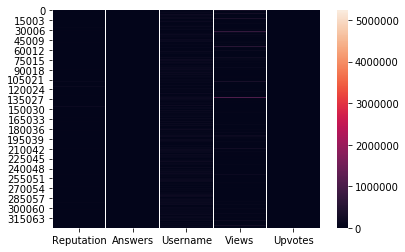

In [28]:
sns.heatmap(trainData.iloc[:,~trainData.columns.isin(['ID','Tag'])])

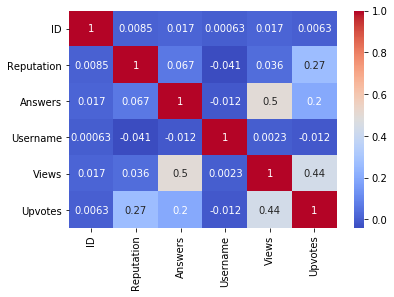

In [29]:
sns.heatmap(trainData.corr(),annot=True,cmap='coolwarm')
#strong variables: Views,Reputation, Answers

In [30]:
####unique values for string col
for col in trainData.columns:
    if(trainData[col].dtypes=='object' or trainData[col].dtypes.name=='category'):
        print(col)
        print(trainData[col].unique())
        print(len(trainData[col].unique()))

Tag
[a, c, r, j, p, s, h, o, i, x]
Categories (10, object): [a, c, r, j, ..., h, o, i, x]
10


In [31]:
trainData.columns

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')

In [32]:
trainData.groupby('Username')['Reputation'].mean()

Username
0              0.0
1              0.0
2              0.0
3           3260.0
5           1933.0
6           7705.0
9              0.0
10             0.0
11             0.0
12          7705.0
13          7705.0
14             0.0
17             0.0
18             0.0
21             1.0
22           172.0
26           637.0
28          1797.0
29             0.0
30          3260.0
31             0.0
32             0.0
36           152.0
37             0.0
38             0.0
39             0.0
41             0.0
43             0.0
46             0.0
47           331.0
            ...   
175701        36.0
175702      1441.0
175703       535.0
175704       403.0
175705        27.0
175706        55.0
175707       429.0
175708       573.0
175710        48.0
175711       162.0
175712       108.0
175713        54.0
175714       667.0
175716         8.0
175719      1019.0
175720       422.0
175721    102036.0
175723      9379.0
175724       117.0
175725       123.0
175726       566.0
175

In [33]:
trainData.groupby('Tag')['Views'].mean()

Tag
a    31800.916327
c    26746.676875
h    33948.958812
i    15806.680093
j    43291.211236
o    13504.645538
p    33184.984334
r    12033.055940
s    25807.082965
x    16119.253941
Name: Views, dtype: float64

In [34]:
trainData.groupby('Tag')['Views','Answers'].sum()

,Views,Answers
Tag,,
a,1007930043,134995
c,1938010713,293288
h,698126389,77708
i,512136435,119224
j,3127010770,314011
o,196438574,49175
p,1440460615,172633
r,149715282,28670
s,601898596,83983


In [35]:
trainData.groupby('Tag')['Reputation','Answers'].sum()

,Reputation,Answers
Tag,,
a,192235503,134995
c,765621708,293288
h,143641023,77708
i,169739851,119224
j,598480239,314011
o,82283167,49175
p,349949536,172633
r,65821690,28670
s,152664466,83983


In [36]:
trainData.groupby('Tag')['Reputation','Answers','Views'].sum()

,Reputation,Answers,Views
Tag,,,
a,192235503,134995,1007930043
c,765621708,293288,1938010713
h,143641023,77708,698126389
i,169739851,119224,512136435
j,598480239,314011,3127010770
o,82283167,49175,196438574
p,349949536,172633,1440460615
r,65821690,28670,149715282
s,152664466,83983,601898596


In [ ]:
###### data exploration queries

In [37]:
len(trainData['Username'].unique())

141802

In [38]:
### max upvotes?
trainData.loc[trainData['Upvotes']==trainData['Upvotes'].max()]     #author :88862  tag: j  qid : 160061

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
86457,160061,j,491244,39,88862,1815987,615278


In [39]:
### which author has max reputation score?
trainData.loc[trainData['Reputation']==trainData['Reputation'].max()]   #46604

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
160728,199859,c,1042428,4,46604,14307,11844
163006,158624,c,1042428,4,46604,5987,4414
206130,470952,c,1042428,5,46604,22088,21675
236399,232318,c,1042428,11,46604,17510,15453
263169,149034,c,1042428,10,46604,26083,24119
323830,466161,c,1042428,5,46604,21245,29012


In [ ]:
############category feature : Tag
# https://www.quora.com/What-are-the-feature-selection-options-for-categorical-data
#- anova test for correlation ( feature selection) https://pythonfordatascience.org/anova-python/
# - check for feature importance including categorical var

In [ ]:
trainData['Tag_category']=trainData['Tag'].astype('category').cat.codes


In [ ]:
tag_count = trainData['Tag'].value_counts()
sns.set(style="darkgrid")
sns.barplot(tag_count.index, tag_count.values)
plt.title('Frequency Distribution of Tags')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.show()

In [ ]:
###to be tried later
# sns.pairplot(trainData')

In [ ]:
###\feature scaling
# StandardScaler()


In [ ]:
####train validation split 

In [45]:
traindata_X=trainData.iloc[:,~trainData.columns.isin(['Upvotes'])]
traindata_Y=trainData['Upvotes']
print(traindata_X.shape)
print(traindata_Y.shape)

(330045, 6)
(330045,)


In [46]:
X_train, X_val, y_train, y_val = train_test_split(traindata_X, traindata_Y, test_size=0.40, random_state=42)
print(f'X train :{X_train.shape}')
print(f'Y train :{y_train.shape}')
print(f'X Val :{X_val.shape}')
print(f'Y val :{y_val.shape}')


X train :(198027, 6)
Y train :(198027,)
X Val :(132018, 6)
Y val :(132018,)


In [ ]:
y_train[0:5]

In [ ]:
sns.scatterplot(x='Reputation',y='Upvotes',data=trainData)

In [ ]:
plt.plot(trainData['Reputation'],trainData['Upvotes'],'--')

In [ ]:
sns.scatterplot(x='Answers',y='Upvotes',data=trainData)
# par = np.polyfit(xd, yd, 1, full=True)


In [ ]:
plt.plot(trainData['Answers'],trainData['Upvotes'],'--')

In [ ]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b



In [ ]:
m, b = best_fit_slope_and_intercept(trainData['Reputation'],trainData['Upvotes'])
print(m,b)
regression_line = [(m*x)+b for x in trainData['Reputation']]
sns.scatterplot(x='Reputation',y='Upvotes',data=trainData)
plt.plot(trainData['Reputation'], regression_line)
plt.show()

In [ ]:
# axes = plt.gca()
# axes.set_xlim([trainData['Answers'].min(),trainData['Answers'].max()])
# axes.set_ylim([trainData['Upvotes'].min(),trainData['Upvotes'].max()])
m, b = best_fit_slope_and_intercept(trainData['Answers'],trainData['Upvotes'])
print(m,b)
regression_line = [(m*x)+b for x in trainData['Answers']]
sns.scatterplot(x='Answers',y='Upvotes',data=trainData)
plt.plot(trainData['Answers'], regression_line)
plt.show()

In [ ]:
m, b = best_fit_slope_and_intercept(trainData['Views'],trainData['Upvotes'])
print(m,b)
regression_line = [(m*x)+b for x in trainData['Views']]
sns.scatterplot(x='Views',y='Upvotes',data=trainData)
plt.plot(trainData['Views'], regression_line)
plt.show()

In [ ]:
###########FEWATURE SELECTION AND MODEL
##following methods not working for categorical vars

#### RFE and LR

In [ ]:
###### feature selection using RFE
estimator=LinearRegression()
selector=RFE(estimator,3)
selector=selector.fit(X_train,y_train)
print(selector.support_) ##returns an array with boolean values to indicate whether an attribute was selected using RFE 
print(selector.ranking_) ##lower scoere higher ranking
####selected features : 

In [ ]:
###Prediction using rfe
# y_pred=selector.predict(X_val)
# df=pd.DataFrame()
# df['Actual']=y_val
# df['Predicted']=y_pred
# df.head()

In [ ]:
selected_features=['Reputation','Answers','Tag_category']

In [ ]:
X_trainNew=X_train.loc[:,X_train.columns.isin(selected_features)]
X_valNew=X_val.loc[:,X_val.columns.isin(selected_features)]

In [ ]:
X_trainNew.head()

In [ ]:
###Prediction using LR
lr=LinearRegression()
lr=lr.fit(X_trainNew,y_train)
lr.coef_
y_pred=lr.predict(X_valNew)
df=pd.DataFrame()
df['Actual']=y_val
df['Predicted']=y_pred
df.head()

In [ ]:
####wrrong resuts- look into it

#### Univariate methods : SelectKbest- regression

In [ ]:
#apply SelectKBest class to extract top 3 best features
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X_train,y_train)


In [ ]:
df=pd.DataFrame()
df['Columns'] = X_train.columns
df['Scores'] = fit.scores_
#concat two dataframes for better visualization 
print(df.nlargest(3,'Scores'))  #print 10 best features

#### Greedy method

In [42]:
selected_features=['Reputation','Answers','Views','Tag']

In [47]:
X_trainNew=X_train.loc[:,X_train.columns.isin(selected_features)]
X_valNew=X_val.loc[:,X_val.columns.isin(selected_features)]

In [48]:
##sample 1
estimator=LinearRegression()
selector = RFECV(estimator, cv=10,scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
print(f'Optimal number of features: {selector.n_features_}')
print(X_train.columns[selector.support_])

ValueError: could not convert string to float: 'h'

In [ ]:
##sample 2
estimator=LinearRegression()
selector = RFECV(estimator, cv=10,scoring='neg_mean_squared_error')
selector.fit(X_val, y_val)
print(f'Optimal number of features: {selector.n_features_}')
print(X_train.columns[selector.support_])

In [ ]:
####LR MODEL

In [ ]:
selected_features=['Views','Reputation','Answers']

In [ ]:
X_trainNew=X_train.loc[:,X_train.columns.isin(selected_features)]
X_valNew=X_val.loc[:,X_val.columns.isin(selected_features)]

In [ ]:
X_trainNew.head()

In [ ]:
###Prediction using LR
lr=LinearRegression()
lr=lr.fit(X_train,y_train)
print(lr.coef_)
y_pred=lr.predict(X_val)
df=pd.DataFrame()
df['Actual']=y_val
df['Predicted']=y_pred
df.head()
print(f'RMS error: {sqrt(mean_squared_error(y_val,y_pred))}')

In [ ]:
###Prediction using LR with reduced features
lr=LinearRegression()
print('Selected features:', X_trainNew.columns)
lr=lr.fit(X_trainNew,y_train)
print(lr.coef_)
y_pred=lr.predict(X_valNew)
df=pd.DataFrame()
df['Actual']=y_val
df['Predicted']=y_pred
df.head()
print(f'RMS error: {sqrt(mean_squared_error(y_val,y_pred))}')

In [ ]:
rscores=cross_val_score(lr,X_trainNew,y_train,cv=5,scoring='r2')
mean_rscore=np.mean(rscores)
print(f'Mean R2 score :{mean_rscore}')

In [ ]:
###Prediction using SVR
svr=SVR(kernel='linear',C=100, gamma='auto')
svr=svr.fit(X_train,y_train)
print(svr.coef_)
y_pred=svr.predict(X_val)
df=pd.DataFrame()
df['Actual']=y_val
df['Predicted']=y_pred
df.head()


In [ ]:
X_train.columns

In [ ]:
###Prediction using RF
rf=RandomForestRegressor(criterion='mse')
rf=rf.fit(X_train,y_train)
print(rf.feature_importances_ )
y_pred=rf.predict(X_val)
df=pd.DataFrame()
df['Actual']=y_val
df['Predicted']=y_pred
df.head()
print(f'RMS error: {sqrt(mean_squared_error(y_val,y_pred))}')

In [ ]:
rscores=cross_val_score(rf,X_train,y_train,cv=5,scoring='r2')
print(rscores)
mean_rscore=np.mean(rscores)
print(f'Mean R2 score :{mean_rscore}')

In [ ]:
###Prediction using RF with reduced features
rf=RandomForestRegressor(criterion='mse')
print('Selected features:', X_trainNew.columns)
rf=rf.fit(X_trainNew,y_train)
# print(rf.feature_importances_ )
y_pred=rf.predict(X_valNew)
df=pd.DataFrame()
df['Actual']=y_val
df['Predicted']=y_pred
df.head()
print(f'RMS error: {sqrt(mean_squared_error(y_val,y_pred))}')

In [ ]:
rscores=cross_val_score(rf,X_trainNew,y_train,cv=5,scoring='r2')
print(rscores)
mean_rscore=np.mean(rscores)
print(f'Mean R2 score :{mean_rscore}')

In [ ]:
###Prediction using Ridge regression


In [ ]:
###Prediction using Ridge regression with reduced features


In [ ]:
###Prediction using Lasso regression


In [ ]:
###Prediction using Lasso regression with reduced features


In [ ]:
#### encoding
# print(testData['Tag'].astype('category').cat.codes.unique())
# print(testData['Tag'].unique())

In [ ]:
# trainData['Tag_category']=trainData['Tag'].astype('category').cat.codes


In [ ]:
####